In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
os.path.dirname(sys.executable)
sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [14]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.ssupergan_dataset import SSGANDataset
from data.datasets.ssupergan_preprocess import *
from data.datasets.ssupergan_dataset import *
from data.augment import get_PIL_image

from networks.plain_ssupervae import PlainSSuperVAE
from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from functional.metrics.dissimilarity import *
from training.face_recognition_trainer import train_epochs
from configs.base_config import *
from functional.losses.elbo import elbo

In [4]:
config = read_config(Config.PLAIN_SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)
    
face_annots, _ = read_face_detection_annotations(golden_age_config.annot_path)
    
folder_structure = return_folder_structure()
face_annots, _ = read_face_detection_annotations(golden_age_config.annot_path, conf_thold=golden_age_config.face_confidence)
    
all_possible_panel_sequence_face_detection = return_all_possible_panel_seq_face_detection(face_annots)
valid_sequences = valid_sequence_creator_from_face_annotations(all_possible_panel_sequence_face_detection, folder_structure)
    
annotations = create_annotation_file(valid_sequences)[:18800]

data = create_dataset_SSGAN(annotations, face_annots, resize_dimension=golden_age_config.panel_dim, face_resize=(config.image_dim, config.image_dim))

  1%|          | 27/3931 [00:00<00:14, 265.57it/s]

Face Annotations are being readed.


  1%|          | 47/3931 [00:00<00:08, 461.89it/s]

Creating Folder Structure


  1%|          | 35/3931 [00:00<00:11, 346.03it/s]

Face Annotations are being readed.


 31%|███▏      | 1230/3917 [00:00<00:00, 6217.34it/s]

Creating all possible panels annotations according to face annotations that came from Face Detector


 26%|██▋       | 1033/3917 [00:00<00:00, 5286.57it/s]

Valid Sequences that are being extracted from all_possible_panel_sequence annotations


100%|██████████| 3917/3917 [00:00<00:00, 126593.79it/s]

Annotation File is being created return DataFrame


In [5]:
data_loader = DataLoader(data, batch_size=1, shuffle=True, num_workers=4)

In [6]:
net = torch.load("weights/08-05-2021-19-15-30_model.pth").to(ptu.device)
net.eval()

PlainSSuperVAE(
  (encoder): PlainSequentialEncoder(
    (embedder): CNNEmbedder(
      (model): EfficientNet(
        (_conv_stem): Conv2dStaticSamePadding(
          3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
          (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
        )
        (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_blocks): ModuleList(
          (0): MBConvBlock(
            (_depthwise_conv): Conv2dStaticSamePadding(
              48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
              (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
            )
            (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (_se_reduce): Conv2dStaticSamePadding(
              48, 12, kernel_size=(1, 1), stride=(1, 1)
              (static_padding): Identity()
            )
            (_se_expa

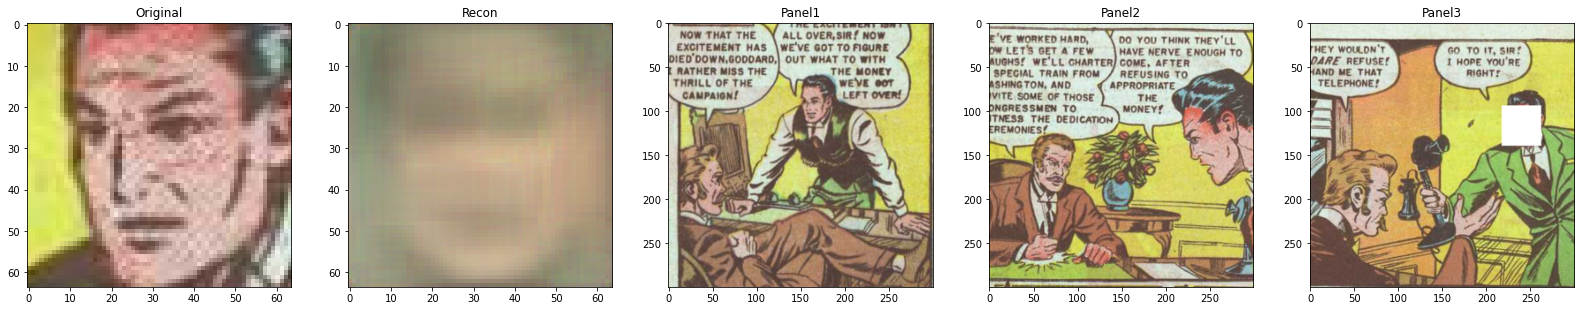

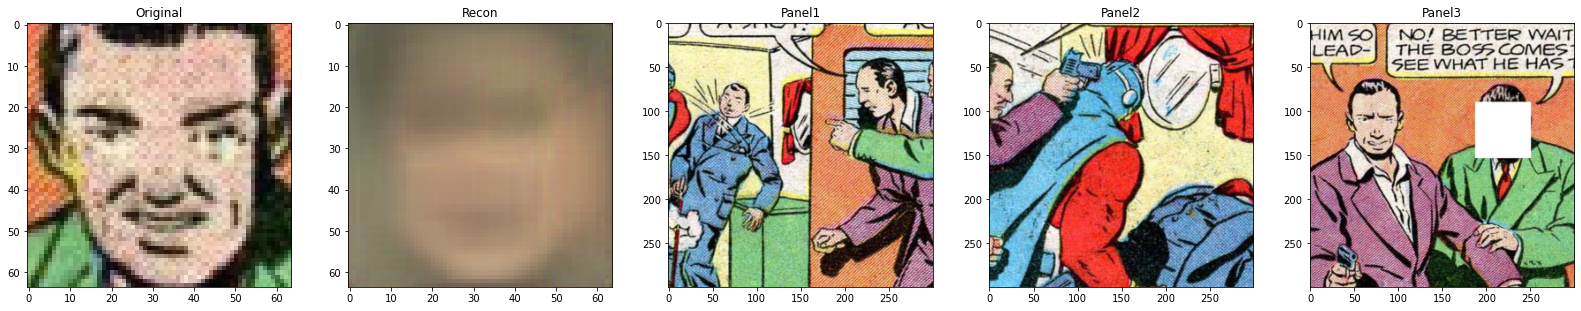

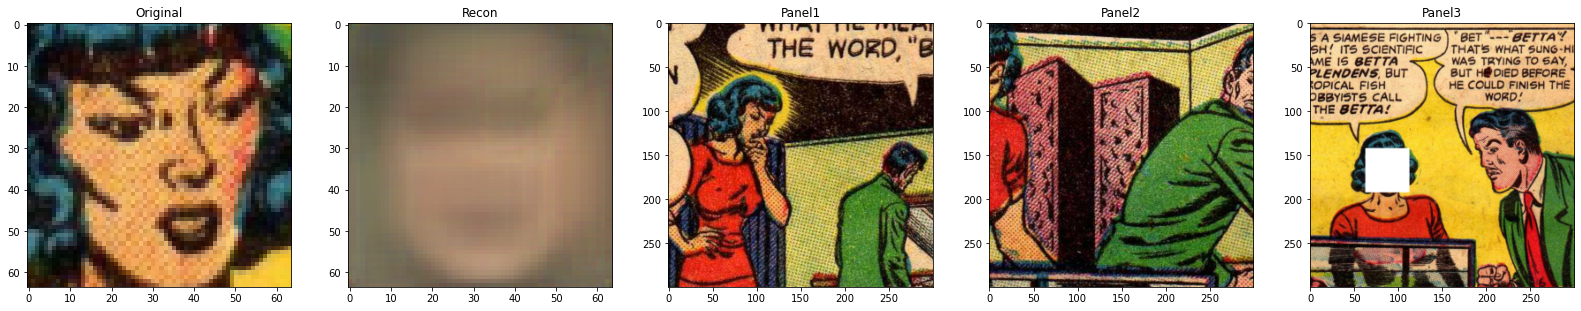

In [12]:
ctr, limit = 0, 3
for x, y in data_loader:
    with torch.no_grad():
        _, _, _, y_recon, _ = net(x.cuda())
    
    y_recon = get_PIL_image(y_recon[0,:,:,:], means=None, stds=None)
    y = get_PIL_image(y[0,:,:,:], means=None, stds=None)
    
    panels = []
    for i in range(x.shape[1]):
        panels.append(get_PIL_image(x[0,i,:,:,:], means=None, stds=None))
    
    w, h = panels[0].size
    wsize, hsize = x.shape[1] + 2, 1
    w = (w + 100) * wsize
    h = (h + 50) * hsize
    
    px = 1/plt.rcParams['figure.dpi']
    f, ax = plt.subplots(hsize, wsize)
    f.set_size_inches(w*px, h*px)
    
    ax[0].imshow(y)
    ax[0].title.set_text("Original")
    
    ax[1].imshow(y_recon)
    ax[1].title.set_text("Recon")
    
    for i in range(len(panels)):
        ax[i+2].imshow(panels[i])
        ax[i+2].title.set_text("Panel" + str(i+1))
    
    plt.show()
    
    ctr += 1
    if ctr >= limit:
        break

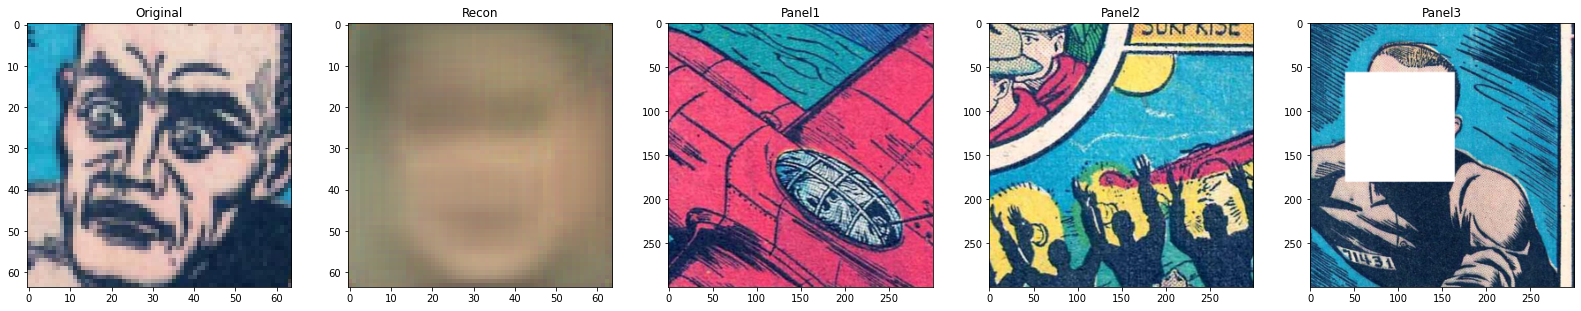

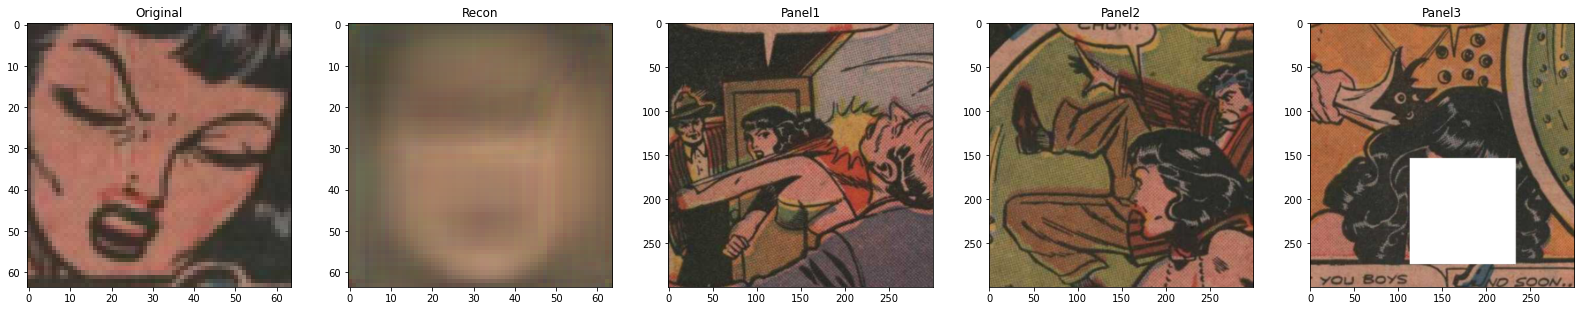

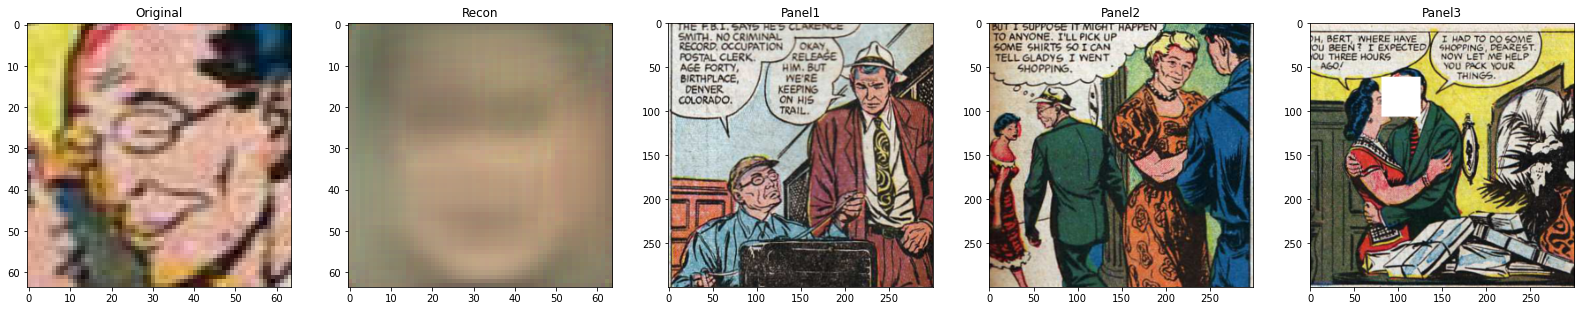

In [15]:
ctr, limit = 0, 3
for x, y in data_loader:
    with torch.no_grad():
        _, _, _, y_recon, _ = net(x.cuda())
        
    plot_panels_and_faces(x, y, y_recon)
    
    ctr += 1
    if ctr >= limit:
        break  